# Importing Libraries

In [1]:
import os
import re
import chardet
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import subprocess
from itertools import product

# Getting information about your machine

For measuring the cpu efficiency, we assume that all the processors are being used in the code. If that's not the case, modify the value of the variable below

In [2]:
num_processors = multiprocessing.cpu_count()

num_processors

16

# Running tests

In [10]:
def run_tests(parameters, static_args):
    # Set the path to the batch file (USING ABSOLUTE PATH)
    batch_file_path = 'D:/Workspace/BIA/Semestre 5/Computação de Alto Desempenho/ParalellCryptoMining/timer/time_miners.bat'
    
    # Iterate through the parameters and construct the command-line arguments
    for param, values in parameters.items():
        for value in values:
            args = [f'{param}={value}']
            
            # Add the static arguments
            args.extend([f'{key}={value}' for key, value in static_args.items()])
            
            # Construct the command to run the batch file
            command = [batch_file_path] + args
            
            print(f"Running: {command}")

            # Execute the command, setting the working directory
            subprocess.run(command, cwd='../timer')


    print("All tests completed.")

In [11]:
parameters = {'difficulty': [1, 2, 3, 4, 5, 6, 7]}
static_args = {'numBlocks': 20}

run_tests(parameters, static_args)

Running: ['D:/Workspace/BIA/Semestre 5/Computação de Alto Desempenho/ParalellCryptoMining/timer/time_miners.bat', 'difficulty=1', 'numBlocks=20']
Running: ['D:/Workspace/BIA/Semestre 5/Computação de Alto Desempenho/ParalellCryptoMining/timer/time_miners.bat', 'difficulty=2', 'numBlocks=20']
Running: ['D:/Workspace/BIA/Semestre 5/Computação de Alto Desempenho/ParalellCryptoMining/timer/time_miners.bat', 'difficulty=3', 'numBlocks=20']
Running: ['D:/Workspace/BIA/Semestre 5/Computação de Alto Desempenho/ParalellCryptoMining/timer/time_miners.bat', 'difficulty=4', 'numBlocks=20']
Running: ['D:/Workspace/BIA/Semestre 5/Computação de Alto Desempenho/ParalellCryptoMining/timer/time_miners.bat', 'difficulty=5', 'numBlocks=20']
Running: ['D:/Workspace/BIA/Semestre 5/Computação de Alto Desempenho/ParalellCryptoMining/timer/time_miners.bat', 'difficulty=6', 'numBlocks=20']
Running: ['D:/Workspace/BIA/Semestre 5/Computação de Alto Desempenho/ParalellCryptoMining/timer/time_miners.bat', 'difficult

# Getting the data and calculating metrics

In [12]:
# Path to the results folder
results_path = '../results'

default_parameters = {
    "difficulty": 4,
    "size": 0,
    "capacity": 10,
    "numBlocks": 5
}

In [13]:
def initialize_dataset(results_folder, default_parameters):
    # List to store the data
    data = []

    # Iterate through the files in the results folder
    for filename in os.listdir(results_folder):
        if filename.endswith('.txt'):
            file_path = os.path.join(results_folder, filename)
            with open(file_path, 'rb') as file:
                rawdata = file.read()
                result = chardet.detect(rawdata)
                file_encoding = result['encoding']
            with open(file_path, 'r', encoding=file_encoding, errors='ignore') as file:
                content = file.read()
                lines = content.split('\n')  # Split content into lines

                # Find the lines that contain "TotalSeconds" and extract the corresponding values
                total_seconds_values = [float(line.split(':')[1].strip().replace(',', '.')) for line in lines if 'TotalSeconds' in line]

                if len(total_seconds_values) == 3:
                    sequential_time, cpu_time, gpu_time = total_seconds_values
                else:
                    print(f"Time values not found in expected format in {filename}")
                    continue

                # Extract parameters from the filename
                parameters = default_parameters.copy()
                for param in re.findall(r'_(\w+)=(\d+)', filename):
                    key, value = param
                    parameters[key] = int(value)

                # Calculate speedup
                cpu_speedup = sequential_time / cpu_time
                gpu_speedup = sequential_time / gpu_time

                # Calculate efficiency
                cpu_efficiency = (cpu_speedup / num_processors) * 100

                # Add row to the data list
                row = {
                    'name': filename[:-4],
                    'difficulty': parameters['difficulty'],
                    'size': parameters['size'],
                    'capacity': parameters['capacity'],
                    'numBlocks': parameters['numBlocks'],
                    'sequential_time': sequential_time,
                    'cpu_time': cpu_time,
                    'gpu_time': gpu_time,
                    'cpu_speedup': cpu_speedup,
                    'gpu_speedup': gpu_speedup,
                    'cpu_efficiency': cpu_efficiency
                }
                data.append(row)

    # Create a DataFrame from the data list
    results_df = pd.DataFrame(data)

    return results_df


In [14]:
# Create a DataFrame from the data list
results_df = initialize_dataset(results_path, default_parameters)

# Display the DataFrame
results_df

,name,difficulty,size,capacity,numBlocks,sequential_time,cpu_time,gpu_time,cpu_speedup,gpu_speedup,cpu_efficiency
0,14-08-2023_18-15-02_difficulty=1_numBlocks=20,1,0,10,20,0.396771,0.209456,17.716021,1.894293,0.022396,11.839328
1,14-08-2023_18-15-34_difficulty=2_numBlocks=20,2,0,10,20,0.202931,0.212799,18.772097,0.953629,0.010810,5.960179
2,14-08-2023_18-16-08_difficulty=3_numBlocks=20,3,0,10,20,0.227533,0.220960,18.206115,1.029748,0.012498,6.435925
3,14-08-2023_18-16-42_difficulty=4_numBlocks=20,4,0,10,20,0.593460,0.647355,17.403237,0.916745,0.034101,5.729656
4,14-08-2023_18-17-16_difficulty=5_numBlocks=20,5,0,10,20,7.080314,13.909592,17.313501,0.509024,0.408948,3.181399
5,14-08-2023_18-18-09_difficulty=6_numBlocks=20,6,0,10,20,171.504686,204.137973,17.291910,0.840141,9.918204,5.250881
6,14-08-2023_18-24-57_difficulty=7_numBlocks=20,7,0,10,20,1738.931374,2589.966476,78.573531,0.671411,22.131262,4.196317


# Graphs

In [15]:
def plot_time_vs_metric(df, x_metric):
    # Sort DataFrame by x_metric
    df = df.sort_values(by=x_metric)
    
    plt.figure(figsize=(10, 6))
    
    # Plot Sequential Time
    plt.plot(df[x_metric], df['sequential_time'], label='Sequential Time', color='blue', marker='o')
    
    # Plot CPU Time
    plt.plot(df[x_metric], df['cpu_time'], label='CPU Time (OpenMP)', color='red', marker='s')
    
    # Plot GPU Time
    plt.plot(df[x_metric], df['gpu_time'], label='GPU Time (CUDA)', color='green', marker='^')

    plt.title(f'Time vs {x_metric}')
    plt.xlabel(x_metric)
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()


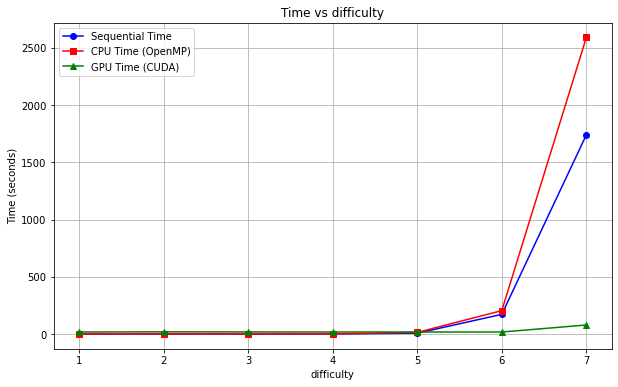

In [16]:
plot_time_vs_metric(results_df, 'difficulty')


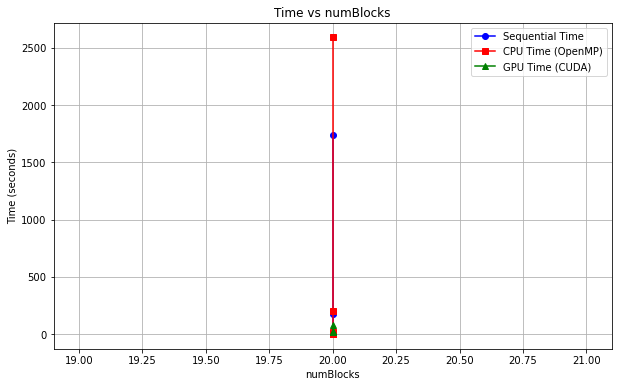

In [17]:
plot_time_vs_metric(results_df, 'numBlocks')
